# ADS Take Home Assignment

## Alex Vand - February 2024

### Purpose of Assignment

The goal of this assignment is to QA/QC, analyze, and draw insights from geologic data.

First, import the necessary packages to complete the assignment.

In [4]:
import pandas as pd # package for data analysis
import numpy as np # package used for "replace" -- is this used otherwise?

In [51]:
from matplotlib import pyplot as plt # package used for data visualization -- is this package used/ needed?

Next read in the raw dataframe and also save a copy of the raw file.

In [652]:
df = pd.read_csv("kobold_data\ADS_Exercise_data\MN_geochem_ads.csv") # read in the dataframe
raw_df = pd.read_csv("kobold_data\ADS_Exercise_data\MN_geochem_ads.csv") # keep a raw copy of the dataframe

The following code chunk displays exploratory information about the dataframe.

In [298]:
df.info(memory_usage='deep') # view basic exploratory information about the dataframe including column names and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sample          305 non-null    int64  
 1   medium          305 non-null    object 
 2   easting_wgs84   305 non-null    float64
 3   northing_wgs84  304 non-null    float64
 4   date_assay      305 non-null    object 
 5   company         305 non-null    object 
 6   structure       110 non-null    object 
 7   lithology       289 non-null    object 
 8   Co_ppm          302 non-null    float64
 9   Cu_ppm          242 non-null    float64
 10  Ni_ppm          305 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 127.1 KB


There are 11 columns (variables of interest) and there are 305 rows (observations/potential mining locations) of data. Additionally, there are both numerical and string data types. As we can see above, there are several null or NA variables that must be addressed/ accounted for. The following code chunk will display the current total number of null values in the raw dataset.

In [693]:
print(df.isna().sum()) # counts the number of NA (null) values in each column

sample             0
medium             0
easting_wgs84      0
northing_wgs84     1
date_assay         0
company            0
structure          0
lithology          0
Co_ppm             3
Cu_ppm            65
Ni_ppm             6
dtype: int64


# Data Cleaning

To clean this dataset, first we will remove all duplicates and address any NA values. Additionally, we will incorporate user testing to show appropriate ranges or variable types for data values.

## Duplicates

The "sample" ID column is the unique identifier/ key to identify each data point/ observation/ potential mining location. Therefore, we can use this column to search for any duplicate entries in the data set and delete those rows.

The code belows displays all the duplicate values.

In [406]:
df[df.duplicated(['sample'], keep = False)] # "keep = false" displays all duplicates instead of ignoring the first or last

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
223,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basaltt,42.0,100.0,41
233,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt.,59.0,83.0,172
300,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt,36.0,110.0,41
301,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt,52.0,58.0,242
302,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,Basalt,42.0,100.0,41
303,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41
304,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41


Sample 9497291 has all the same values, for all variables, for all 4 duplicate entries [indices 223, 302, 303, 304]. Therefore, we can delete all repeated duplicates and just keep the first entry.

Sample 9497345, however, has different values for the metal concentrations for all 3 duplicate entries [indices 233, 300, 301]. This implies we cannot keep any of the 3 data points in our dataframe as we do not know which one is correct. If possible, we could ask a field team or refer to the metadata to answer any potential questions or solve any problems. Alternatively, we could consider taking the average value of the 3 duplicate data entries and including that number in our clean dataset. However the values are very different; so for the sake of this exercise, these data points will be considered NA values. Another option would be to assign a new sample number or identifier to each of the duplicate samples that hace different mineral concentration values. For example, indices 300 and 301 could be assigned new sample numbers and those data points could be included in the final clean dataset.

## Latitude and Longitude Errors

There are several data points where the latitude ("northing_wgs84") and longitude ("easting_wgs84") are flipped and/or one of the values has the incorrect positive or negative sign. These data points must be corrected so they can be included in the calculations for spatial analysis. Below we see a map of all of our raw data points.

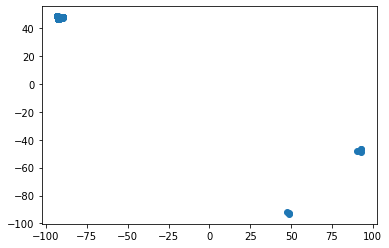

In [694]:
plt.scatter(raw_df['easting_wgs84'], df['northing_wgs84'])

First we will swap any latitude ("northing_wgs84") and longitude ("easting_wgs84") points that appear to be in the opposite column. The following code chunk displays the data points where this switch must occur.

In [696]:
easting_min = df['easting_wgs84'].min()
easting_max = df['easting_wgs84'].max()

print("The range for 'easting_wgs84' is between", easting_min, "and", easting_max, "degrees.")

The range for 'easting_wgs84' is between -93.35 and 92.93611 degrees.


In [697]:
northing_min = df['northing_wgs84'].min()
northing_max = df['northing_wgs84'].max()

print("The range for 'northing_wgs84' is between", northing_min, "and", northing_max, "degrees.")

The range for 'northing_wgs84' is between -93.2 and 48.66667 degrees.


In [527]:
df.loc[(abs(df['easting_wgs84']) < 50)] # lists the data points where lat & long need to swap

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
21,9177307,rock_outcrop,48.41581,-92.52700,11/6/01,united_states_geological_survey,pluton; stock,granite,3.0,4.0,NaN
70,9278672,rock_outcrop,48.63333,-93.20000,11/14/83,united_states_geological_survey,xenolith,diorite,66.0,43.0,640
161,9334348,rock,47.61861,-91.93222,1/2/88,united_states_geological_survey,NaN,gabbro,22.5,75.0,75


Next, we will update the dataset and actually switch the northing and easting values for all three data observations listed above.

In [698]:
df[['easting_wgs84','northing_wgs84']] = df[['northing_wgs84','easting_wgs84']].where(abs(df['easting_wgs84']) < 50,
                                                                                      df[['easting_wgs84','northing_wgs84']].values)
df[['easting_wgs84','northing_wgs84']]

,easting_wgs84,northing_wgs84
0,-93.16750,48.60222
1,-93.16750,48.60222
2,-93.11861,48.60639
3,-93.11861,48.60639
4,92.70556,-48.51444
...,...,...
300,-90.41667,47.75000
301,-90.41667,47.75000
302,-90.33333,48.00000
303,-90.33333,48.00000


Here we multiply the absolute value of the easting value by -1 to make sure all the longitude values are negative and reflect the geographic location in the Western Hemisphere.

In [699]:
df['easting_wgs84'] = df['easting_wgs84'].apply(abs)*(-1) # ensures that all longitude values are negative (Western Hemisphere)
print(df['easting_wgs84'])

0     -93.16750
1     -93.16750
2     -93.11861
3     -93.11861
4     -92.70556
         ...   
300   -90.41667
301   -90.41667
302   -90.33333
303   -90.33333
304   -90.33333
Name: easting_wgs84, Length: 305, dtype: float64


Below we find the absolute value of all northing values to make sure all the latitude values are positive and reflect the geographic location in the Northern Hemisphere.

In [700]:
df['northing_wgs84'] = df['northing_wgs84'].apply(abs) # ensures that all latitude values are positive (Northern Hemisphere)
print(df['northing_wgs84'])

0      48.60222
1      48.60222
2      48.60639
3      48.60639
4      48.51444
         ...   
300    47.75000
301    47.75000
302    48.00000
303    48.00000
304    48.00000
Name: northing_wgs84, Length: 305, dtype: float64


In the map below, using the updated dataframe, we see that all data points are relegated to the same geogaphical area in Canada.

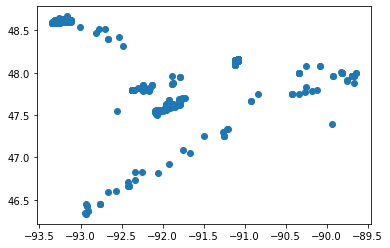

In [701]:
plt.scatter(df['easting_wgs84'], df['northing_wgs84'])

## NA Values

The `unique` function will list all the unique values for a given column. The `min` and `max` functions can be used to display the ranges for each of the mineral concentration columns.

In [702]:
np.unique(df['Co_ppm']) # this only works after using fillna function to add "unknown" string

array([1.000e-01, 1.200e-01, 4.100e-01, 4.300e-01, 5.000e-01, 6.250e-01,
       1.000e+00, 1.200e+00, 1.250e+00, 1.600e+00, 1.750e+00, 1.810e+00,
       2.200e+00, 2.500e+00, 3.000e+00, 3.300e+00, 3.650e+00, 3.750e+00,
       3.970e+00, 4.000e+00, 4.520e+00, 4.970e+00, 5.000e+00, 5.700e+00,
       6.150e+00, 7.000e+00, 7.200e+00, 7.260e+00, 7.500e+00, 8.000e+00,
       8.590e+00, 9.800e+00, 1.000e+01, 1.030e+01, 1.100e+01, 1.250e+01,
       1.300e+01, 1.360e+01, 1.380e+01, 1.400e+01, 1.450e+01, 1.460e+01,
       1.500e+01, 1.600e+01, 1.610e+01, 1.700e+01, 1.750e+01, 1.800e+01,
       1.840e+01, 1.900e+01, 1.910e+01, 2.000e+01, 2.070e+01, 2.080e+01,
       2.090e+01, 2.100e+01, 2.150e+01, 2.170e+01, 2.250e+01, 2.300e+01,
       2.330e+01, 2.350e+01, 2.400e+01, 2.440e+01, 2.470e+01, 2.500e+01,
       2.540e+01, 2.600e+01, 2.630e+01, 2.700e+01, 2.730e+01, 2.820e+01,
       2.900e+01, 2.910e+01, 2.950e+01, 2.960e+01, 2.990e+01, 3.000e+01,
       3.080e+01, 3.200e+01, 3.260e+01, 3.300e+01, 

In [710]:
cobalt_min = df['Co_ppm'].min()
cobalt_max = df['Co_ppm'].max()

print("The range for cobalt is between", cobalt_min, "and", cobalt_max, "ppm.")

The range for cobalt is between 0.1 and 768.0 ppm.


Because these values represent mineral concentrations, negative values are nonsensical. We could make the choice to consider all negative values as NA; however, since the negative values included in this column are within a reasonalbe range if they were positive, we will convert these values to positive numbers in a later step and keep them for our future analysis.

In [704]:
copper_min = df['Cu_ppm'].min()
copper_max = df['Cu_ppm'].max()

print("The range for copper is between", copper_min, "and", copper_max, "ppm.")

The range for copper is between 0.4 and 2617.5 ppm.


Here we see that the copper values include common NA identifiers such as -99999 and 99999. We must convert these values to NA in a later step as well.

In [705]:
nickel_min = df['Ni_ppm'].min()
nickel_max = df['Ni_ppm'].max()

print("The range for nickel is between", nickel_min, "and", nickel_max, "ppm.")

The range for nickel is between 1.25 and 1200.0 ppm.


The nickel data column has a string value listed for very low concentrations ("<1.5"). How to deal...

In [706]:
df[['Ni_ppm']] = df[['Ni_ppm']].mask(df[['Ni_ppm']] == "<1.5") # changes <1.5 values to NA

print(df[['Ni_ppm']])

     Ni_ppm
0      75.0
1      44.0
2      18.0
3      32.0
4      77.0
..      ...
300    41.0
301   242.0
302    41.0
303    41.0
304    41.0

[305 rows x 1 columns]


In [707]:
df.Ni_ppm = df.Ni_ppm.astype(float) # converts data type to float so that we can apply absolute value function in next code chunk

In [708]:
df[['Co_ppm','Cu_ppm','Ni_ppm']] = df[['Co_ppm','Cu_ppm','Ni_ppm']].apply(abs)

print(df[['Co_ppm','Cu_ppm','Ni_ppm']])

     Co_ppm  Cu_ppm  Ni_ppm
0      21.0    36.0    75.0
1      29.0   198.0    44.0
2      11.0    91.0    18.0
3      17.0    63.0    32.0
4      18.0    28.0    77.0
..      ...     ...     ...
300    36.0   110.0    41.0
301    52.0    58.0   242.0
302    42.0   100.0    41.0
303    42.0   100.0    41.0
304    42.0   100.0    41.0

[305 rows x 3 columns]


In [662]:
df[['Cu_ppm']] = df[['Cu_ppm']].mask(df[['Cu_ppm']] == abs(99999)) # changes 99999 values to NA

print(df[['Cu_ppm']])

     Cu_ppm
0      36.0
1     198.0
2      91.0
3      63.0
4      28.0
..      ...
300   110.0
301    58.0
302   100.0
303   100.0
304   100.0

[305 rows x 1 columns]


In [713]:
print(df.isna().sum()) # counts the number of NA (null) values in each column

sample             0
medium             0
easting_wgs84      0
northing_wgs84     1
date_assay         0
company            0
structure          0
lithology          0
Co_ppm             3
Cu_ppm            65
Ni_ppm             6
dtype: int64


Cobalt has 8 (3), Copper has 69 (2 + 63 = 65), and Nickel has 7 (6) total NA values. *THESE ARE CORRECT VALUES (converting negative values to positive)*

Notice that the total count of NA values increases.

In [686]:
df.structure.fillna(value = "unknown", inplace = True) # change NA values in "Structure" column to "unknown" string
df.lithology.fillna(value = "unknown", inplace = True) # change NA values in "Lithology" column to "unknown" string

In [668]:
df.lithology = df.lithology.str.lower() # change all lithology types to lower case letters for uniformity

In [716]:
df.lithology.replace(('Basalt','basalt.','bassalt','basaltt'), 'basalt', inplace = True) # change all "basalt" typos

In [717]:
df.lithology.replace(('GABBRO', 'gabro'), 'gabbro', inplace = True) # change all "gabbro" typos

In [46]:
df.lithology.replace('meta-andesite', 'metaandesite', inplace = True) # drop the dash for consistency in lithology names

In [669]:
df.lithology.replace('meta-graywacke', 'metagraywacke', inplace = True) # drop the dash for consistency in lithology names

In [682]:
df.lithology.replace('none', 'unknown', inplace = True) # is none the same as unknown?

In [711]:
df.lithology.replace('unknown', np.NaN, inplace = True)

In [714]:
np.unique(df['lithology']) # this only works after using fillna function to add "unknown" string

array(['UNKONWN', 'andesite', 'argillite', 'basalt', 'basalt.', 'basaltt',
       'bassalt', 'chert', 'dacite', 'diorite', 'felsic', 'gabbro',
       'gabro', 'granite', 'granodiorite', 'graywacke', 'greenstone',
       'hornfels', 'meta-andesite', 'metafelsite', 'metagraywacke',
       'metasediment', 'metasiltstone', 'monzonite', 'pegmatite',
       'rhyolite', 'sandstone', 'schist', 'shale', 'siliciclastic',
       'tuff'], dtype=object)

## Compare Basalt and Gabbro

First we will subset the clean dataframe to only include lithologies with basalt and gabbro.

In [750]:
df_subset = df[df["lithology"].isin(["basalt", 'gabbro'])] # should contain 103 rows
print(df_subset)

      sample        medium  easting_wgs84  northing_wgs84 date_assay  \
8    9177294  rock_outcrop      -89.82863        48.00460    11/6/01   
9    9177295  rock_outcrop      -89.80772        48.00198    11/6/01   
10   9177296          rock      -89.80772        48.00198    11/6/01   
13   9177299  rock_outcrop      -89.68931        47.96223    11/6/01   
14   9177300  rock_outcrop      -89.68931        47.96223    11/6/01   
..       ...           ...            ...             ...        ...   
300  9497345  rock_outcrop      -90.41667        47.75000     4/5/89   
301  9497345  rock_outcrop      -90.41667        47.75000     4/5/89   
302  9497291  rock_outcrop      -90.33333        48.00000    3/20/89   
303  9497291  rock_outcrop      -90.33333        48.00000    3/20/89   
304  9497291  rock_outcrop      -90.33333        48.00000    3/20/89   

                             company              structure lithology  Co_ppm  \
8    united_states_geological_survey  dike; sill; lacc

In order to perform OLS regression, we need to assign dummy variables to our categorical (in this case, binary) variable of interest.

In [807]:
df_subset.lithology.replace("basalt", 1, inplace = True)
df_subset.lithology.replace("gabbro", 0, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [806]:
df_subset.head

<bound method NDFrame.head of       sample        medium  easting_wgs84  northing_wgs84 date_assay  \
8    9177294  rock_outcrop      -89.82863        48.00460    11/6/01   
9    9177295  rock_outcrop      -89.80772        48.00198    11/6/01   
10   9177296          rock      -89.80772        48.00198    11/6/01   
13   9177299  rock_outcrop      -89.68931        47.96223    11/6/01   
14   9177300  rock_outcrop      -89.68931        47.96223    11/6/01   
..       ...           ...            ...             ...        ...   
300  9497345  rock_outcrop      -90.41667        47.75000     4/5/89   
301  9497345  rock_outcrop      -90.41667        47.75000     4/5/89   
302  9497291  rock_outcrop      -90.33333        48.00000    3/20/89   
303  9497291  rock_outcrop      -90.33333        48.00000    3/20/89   
304  9497291  rock_outcrop      -90.33333        48.00000    3/20/89   

                             company              structure  lithology  \
8    united_states_geological_s

Text(0, 0.5, 'Frequency')

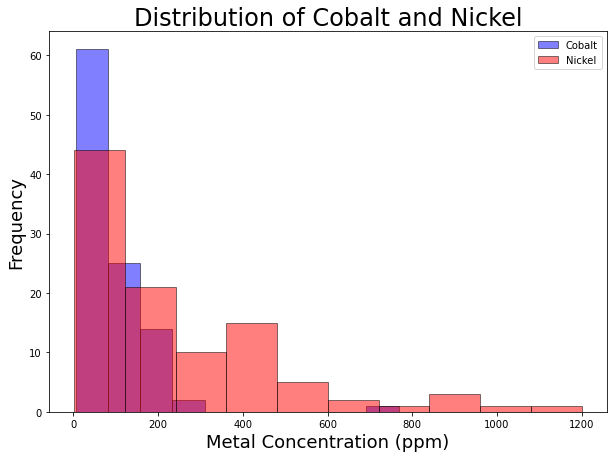

In [810]:
df_subset.Co_ppm.plot(kind='hist', color='blue', edgecolor='black', alpha = 0.5, figsize=(10,7))
df_subset.Ni_ppm.plot(kind='hist', color='red', edgecolor='black', alpha = 0.5, figsize=(10,7))

plt.title('Distribution of Cobalt and Nickel', size=24)
plt.legend(labels=['Cobalt', 'Nickel'])
plt.xlabel('Metal Concentration (ppm)', size=18)
plt.ylabel('Frequency', size=18)

Because the distributions look somewhat normal (actually they are right skewed - should do a log transformation?), we can do an OLS (ordinary least squares) regression analysis to determine which lithology is more prospective / which lithology better predicts of high concentrations of Cobalt and Nickel ...

In [793]:
from sklearn.linear_model import LinearRegression

# create linear regression object
mlr = LinearRegression()

# fit linear regression
mlr.fit(df_subset[['lithology']], df_subset['Co_ppm'])

# get the slope and intercept of the line best fit.
print(mlr.intercept_)
# -244.92350252069903

print(mlr.coef_)
# [ 5.97694123 19.37771052]

152.54999999999995
[-100.91283019]


For both cobalt and nickel the mrl.coefficient (slope) is a negative value, meaning when basalt (lithology = 1) is accounted for, the average mineral concentration value decreases. This implies that gabbro lithology is more prospective. The p-value is low very close to zero so these values are statistically significant.

In [789]:
from statsmodels.formula.api import ols

model = ols('Co_ppm ~ lithology', data=df_subset)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Co_ppm   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     41.29
Date:                Tue, 13 Feb 2024   Prob (F-statistic):           4.36e-09
Time:                        00:20:02   Log-Likelihood:                -596.04
No. Observations:                 103   AIC:                             1196.
Df Residuals:                     101   BIC:                             1201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.5500     11.265     13.542      0.000     130.204     174.896
lithology   -100.9128     15.704     -6.426      0.000    -132.065     -69.761
==============================================================================
Omnibus:                      136.006   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5166.087
Skew:                           4.438   Prob(JB):                         0.00
Kurtosis:                      36.540   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [791]:
from statsmodels.formula.api import ols

model = ols('Ni_ppm ~ lithology', data=df_subset)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Ni_ppm   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     21.54
Date:                Tue, 13 Feb 2024   Prob (F-statistic):           1.04e-05
Time:                        00:21:14   Log-Likelihood:                -702.29
No. Observations:                 103   AIC:                             1409.
Df Residuals:                     101   BIC:                             1414.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    351.0600     31.602     11.109      0.000     288.369     413.751
lithology   -204.4619     44.056     -4.641      0.000    -291.856    -117.067
==============================================================================
Omnibus:                       47.915   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.286
Skew:                           1.643   Prob(JB):                     1.04e-32
Kurtosis:                       7.850   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Geospatial Analysis

In [691]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

Is the following necessary to do analysis? Do we need to convert NA values to zero?

In [338]:
df.Co_ppm.fillna(value = 0, inplace = True) # change NA values in "Cobalt" column to zero integer vale
df.Cu_ppm.fillna(value = 0, inplace = True) # change NA values in "Copper" column to zero integer vale
df.Ni_ppm.fillna(value = 0, inplace = True) # change NA values in "Nickel" column to zero integer vale